    Andrew Carr
    Math 404
    Feb 9, 2018

In [1]:
import numpy as np
import pandas as pd
import time

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets


from tqdm import tqdm
from graphviz import Source

Helper function

In [2]:
def get_time(func, label="classifier", train=False, score=False):
    # Score asks if you want to get accuracy AND test time. Setting it to false JUST gives test time
    """simplify timing by adding a function to do it for me."""
    print("\n{}:\n".format(label))
    
    # determine type of action
    if train:
        type_of_action = "train"
    else:
        type_of_action = "test"
        
    # run the function
    start = time.time()
    if train:
        func(train_x,train_y)
    else:
        func(test_x,test_y)
        
    print("\t{} time {}".format(type_of_action, time.time() - start))
    if score:
        print("\taccuracy {}".format(func(test_x, test_y)))

# Problem 1
Use scikit learn's decision tree classifier  to predict survival for the titanic dataset (use an 80-20 train-test split).  Experiment with `max_depth` in range(2,10) and `min_samples_leaf` in range(1,102,10) and compare training time and prediction accuracy.  Use the `graphviz` module to draw your most accurate `max_depth=3` tree.  Interpret the results.

In [3]:
# Import dataset.
df = pd.read_csv("titanic.csv")

# Clean Data
df.drop(['Body'],axis=1, inplace=True)
df.drop(['Boat'],axis=1, inplace=True)
df.drop(['home.dest'],axis=1, inplace=True)
df.drop(['Cabin'],axis=1, inplace=True)
df.dropna(axis=0,inplace=True)

df['Sex'] = df['Sex'].astype("category").cat.codes
df['Embarked'] = df['Embarked'].astype("category").cat.codes


# Test train split.
train_x, test_x, train_y, test_y = train_test_split(df[['Pclass','Sex','Age', 'Fare']], df['Survived'], train_size=.8, test_size=0.2)

# Experiment with max_depth and min_samples_leaf.
base_info = {"accuracy":0, "time":0, "max_depth":0, "min_samples_leaf":0, "method": "none"}
meta_data = []

# grid search
for max_depth in range(2,20):
    for min_samples_leaf in range(1,102,10):
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        train_d = base_info.copy()
        test_d = base_info.copy()

        # save train meta data
        start = time.time()
        clf.fit(train_x, train_y)
        train_d['time'] = time.time() - start
        train_d['max_depth'] = max_depth
        train_d['min_samples_leaf'] = min_samples_leaf
        train_d['method'] = 'train'
        
        # save test meta data
        start = time.time()
        acc = clf.score(test_x, test_y)
        test_d['accuracy'] = acc
        test_d['time'] = time.time() - start
        test_d['max_depth'] = max_depth
        test_d['min_samples_leaf'] = min_samples_leaf
        test_d['method'] = 'test'
        meta_data.append(train_d)
        meta_data.append(test_d)
        
# print results of min time and max accuracy across methods
best_train_time = min([i for i in meta_data if i['method'] == 'train'], key=lambda x:x['time'])
print("\nbest train time:",
      "".join(["Time: "+ str(best_train_time['time']) +"\n",
               "Max Depth: "+ str(best_train_time['max_depth']) +"\n",
               "Min Samples Leaf: "+ str(best_train_time['min_samples_leaf'])])
      , sep="\n")

best_test_time = min([i for i in meta_data if i['method'] == 'test'], key=lambda x:x['time'])
print("\nbest test time:",
      "".join(["Time: "+ str(best_test_time['time']) +"\n",
               "Max Depth: "+ str(best_test_time['max_depth']) +"\n",
               "Min Samples Leaf: "+ str(best_test_time['min_samples_leaf']) + "\n",
               "Accuracy: "+ str(best_test_time['accuracy'])])
      , sep="\n")

best_test_accuracy = max([i for i in meta_data if i['method'] == 'test'], key=lambda x:x['accuracy'])
print("\nbest test accuracy:",
      "".join(["Time: "+ str(best_test_accuracy['time']) +"\n",
               "Max Depth: "+ str(best_test_accuracy['max_depth']) +"\n",
               "Min Samples Leaf: "+ str(best_test_accuracy['min_samples_leaf']) + "\n",
               "Accuracy: "+ str(best_test_accuracy['accuracy'])])
      , sep="\n")


best_3_depth = max([i for i in meta_data if i['method'] == 'test' and i['max_depth'] == 3], key=lambda x:x['accuracy'])
print("\nbest 3 depth accuracy:",
      "".join(["Time: "+ str(best_3_depth['time']) +"\n",
               "Max Depth: "+ str(best_3_depth['max_depth']) +"\n",
               "Min Samples Leaf: "+ str(best_3_depth['min_samples_leaf']) + "\n",
               "Accuracy: "+ str(best_3_depth['accuracy'])])
      , sep="\n")


best train time:
Time: 0.0004961490631103516
Max Depth: 2
Min Samples Leaf: 71

best test time:
Time: 0.00032591819763183594
Max Depth: 2
Min Samples Leaf: 61
Accuracy: 0.789473684211

best test accuracy:
Time: 0.00033164024353027344
Max Depth: 3
Min Samples Leaf: 1
Accuracy: 0.808612440191

best 3 depth accuracy:
Time: 0.00033164024353027344
Max Depth: 3
Min Samples Leaf: 1
Accuracy: 0.808612440191


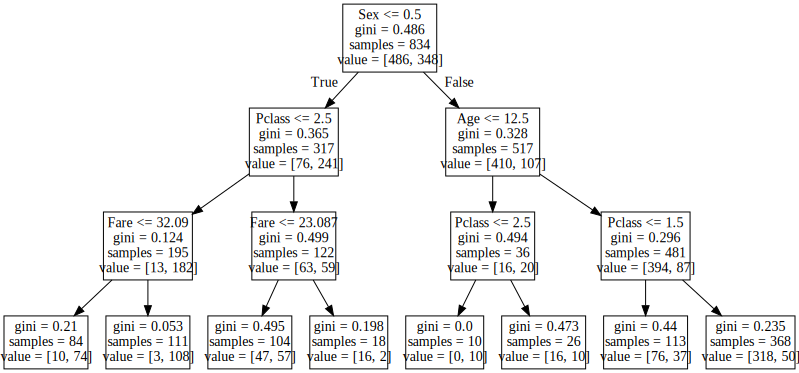

In [4]:
# Use graphviz module
clf = DecisionTreeClassifier(max_depth=best_3_depth['max_depth'], min_samples_leaf=best_3_depth['min_samples_leaf'])
clf.fit(train_x, train_y)
export_graphviz(clf, 'tree.dot',feature_names=train_x.columns)

Source.from_file('tree.dot')

Well we can see that it accurately gets the male female split, which is great. And it knows that p-class matters quite a bit when we care about who survives. We also notice, from our timing above, that a depth of 2 or 3 seems to generalize really well. Which is what we talked about in class. Something that is interesting also, is that it uses fare (Which is highly correlated...confounded...by Pclass)

# Problem 2
Do the same thing as #1, but on a large dataset related to your final project. 

In [5]:
# Import dataset.
df = pd.read_pickle("recipe_data")

# Test train split.
train_x, test_x, train_y, test_y = train_test_split(df[['calories','fat', 'protein', 'sodium']], df['rating_floor'], train_size=.8, test_size=0.2)

# Experiment with max_depth and min_samples_leaf.
base_info = {"accuracy":0, "time":0, "max_depth":0, "min_samples_leaf":0, "method": "none"}
meta_data = []

for max_depth in range(2,20):
    for min_samples_leaf in range(1,102,10):
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        train_d = base_info.copy()
        test_d = base_info.copy()

        start = time.time()
        clf.fit(train_x, train_y)
        train_d['time'] = time.time() - start
        train_d['max_depth'] = max_depth
        train_d['min_samples_leaf'] = min_samples_leaf
        train_d['method'] = 'train'
        
        start = time.time()
        acc = clf.score(test_x, test_y)
        test_d['accuracy'] = acc
        test_d['time'] = time.time() - start
        test_d['max_depth'] = max_depth
        test_d['min_samples_leaf'] = min_samples_leaf
        test_d['method'] = 'test'
        meta_data.append(train_d)
        meta_data.append(test_d)
        
# once again, this is just a convoluted way to get the visualization while saving data so it's logged well
best_train_time = min([i for i in meta_data if i['method'] == 'train'], key=lambda x:x['time'])
print("\nbest train time:",
      "".join(["Time: "+ str(best_train_time['time']) +"\n",
               "Max Depth: "+ str(best_train_time['max_depth']) +"\n",
               "Min Samples Leaf: "+ str(best_train_time['min_samples_leaf'])])
      , sep="\n")

best_test_time = min([i for i in meta_data if i['method'] == 'test'], key=lambda x:x['time'])
print("\nbest test time:",
      "".join(["Time: "+ str(best_test_time['time']) +"\n",
               "Max Depth: "+ str(best_test_time['max_depth']) +"\n",
               "Min Samples Leaf: "+ str(best_test_time['min_samples_leaf']) + "\n",
               "Accuracy: "+ str(best_test_time['accuracy'])])
      , sep="\n")

best_test_accuracy = max([i for i in meta_data if i['method'] == 'test'], key=lambda x:x['accuracy'])
print("\nbest test accuracy:",
      "".join(["Time: "+ str(best_test_accuracy['time']) +"\n",
               "Max Depth: "+ str(best_test_accuracy['max_depth']) +"\n",
               "Min Samples Leaf: "+ str(best_test_accuracy['min_samples_leaf']) + "\n",
               "Accuracy: "+ str(best_test_accuracy['accuracy'])])
      , sep="\n")


best_3_depth = max([i for i in meta_data if i['method'] == 'test' and i['max_depth'] == 3], key=lambda x:x['accuracy'])
print("\nbest 3 depth accuracy:",
      "".join(["Time: "+ str(best_3_depth['time']) +"\n",
               "Max Depth: "+ str(best_3_depth['max_depth']) +"\n",
               "Min Samples Leaf: "+ str(best_3_depth['min_samples_leaf']) + "\n",
               "Accuracy: "+ str(best_3_depth['accuracy'])])
      , sep="\n")


best train time:
Time: 0.003938198089599609
Max Depth: 2
Min Samples Leaf: 61

best test time:
Time: 0.0004010200500488281
Max Depth: 2
Min Samples Leaf: 51
Accuracy: 0.419886899152

best test accuracy:
Time: 0.0007512569427490234
Max Depth: 16
Min Samples Leaf: 1
Accuracy: 0.434024505184

best 3 depth accuracy:
Time: 0.00045299530029296875
Max Depth: 3
Min Samples Leaf: 71
Accuracy: 0.420358152686


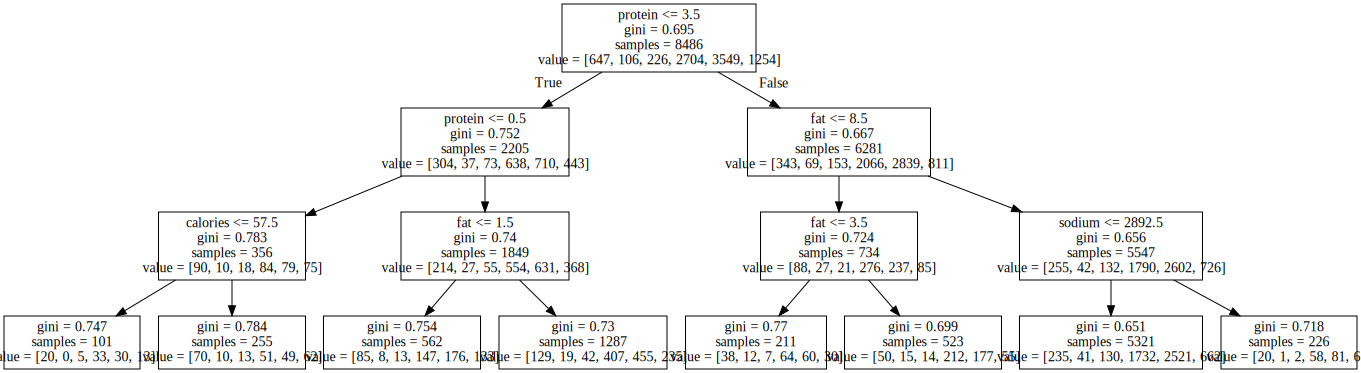

In [6]:
# Use graphviz module
clf = DecisionTreeClassifier(max_depth=best_3_depth['max_depth'], min_samples_leaf=best_3_depth['min_samples_leaf'])
clf.fit(train_x, train_y)
export_graphviz(clf, 'grocery_tree.dot',feature_names=train_x.columns)

Source.from_file('grocery_tree.dot')

This is fascinating! If you follow the high fat, high protein, lower sodium path you find that there are LOTS of high ratings compared to other paths. For example, high sodium content generally has lower ratings. While low fat and low calories doesn't have ANY low rtaings. This is such a fascinating graph. By the way, for base line 16% accuracy would be random guessing. So there is significant improvement over random guessing with my 42% accuracy.

# Problem 3
Use scikit-learn's tree regression on the boston housing dataset to predict housing prices (with 3-fold cross validation). Experiment with `max_depth` in range(2,10) and `min_samples_leaf` in range(1,102,10) and compare training time and prediction accuracy.  Use the `graphviz` module to draw your most accurate `max_depth=3` tree.  Interpret the results.

### Explore the dataset

In [7]:
# Import datset.
data = datasets.load_boston()

# Experiment with max_depth and min_samples_leaf.
base_info = {"accuracy":0, "time":0, "max_depth":0, "min_samples_leaf":0, "method": "none"}
meta_data = []

for max_depth in range(2,20):
    for min_samples_leaf in range(1,102,10):
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        train_d = base_info.copy()
        test_d = base_info.copy()
        
        start = time.time()
        acc = np.mean(cross_val_score(clf, data.data, data.target, cv=3))
        
        train_d['time'] = time.time() - start
        train_d['max_depth'] = max_depth
        train_d['min_samples_leaf'] = min_samples_leaf
        train_d['method'] = 'train'
        
        test_d['accuracy'] = acc
        test_d['time'] = time.time() - start
        test_d['max_depth'] = max_depth
        test_d['min_samples_leaf'] = min_samples_leaf
        test_d['method'] = 'test'
        meta_data.append(train_d)
        meta_data.append(test_d)
        
# once again, this is just a convoluted way to get the visualization while saving data so it's logged well
best_train_time = min([i for i in meta_data if i['method'] == 'train'], key=lambda x:x['time'])
print("\nbest train time:",
      "".join(["Time: "+ str(best_train_time['time']) +"\n",
               "Max Depth: "+ str(best_train_time['max_depth']) +"\n",
               "Min Samples Leaf: "+ str(best_train_time['min_samples_leaf'])])
      , sep="\n")

best_test_time = min([i for i in meta_data if i['method'] == 'test'], key=lambda x:x['time'])
print("\nbest test time:",
      "".join(["Time: "+ str(best_test_time['time']) +"\n",
               "Max Depth: "+ str(best_test_time['max_depth']) +"\n",
               "Min Samples Leaf: "+ str(best_test_time['min_samples_leaf']) + "\n",
               "Accuracy: "+ str(best_test_time['accuracy'])])
      , sep="\n")

best_test_accuracy = max([i for i in meta_data if i['method'] == 'test'], key=lambda x:x['accuracy'])
print("\nbest test accuracy:",
      "".join(["Time: "+ str(best_test_accuracy['time']) +"\n",
               "Max Depth: "+ str(best_test_accuracy['max_depth']) +"\n",
               "Min Samples Leaf: "+ str(best_test_accuracy['min_samples_leaf']) + "\n",
               "Accuracy: "+ str(best_test_accuracy['accuracy'])])
      , sep="\n")


best_3_depth = max([i for i in meta_data if i['method'] == 'test' and i['max_depth'] == 3], key=lambda x:x['accuracy'])
print("\nbest 3 depth accuracy:",
      "".join(["Time: "+ str(best_3_depth['time']) +"\n",
               "Max Depth: "+ str(best_3_depth['max_depth']) +"\n",
               "Min Samples Leaf: "+ str(best_3_depth['min_samples_leaf']) + "\n",
               "Accuracy: "+ str(best_3_depth['accuracy'])])
      , sep="\n")


best train time:
Time: 0.0031387805938720703
Max Depth: 19
Min Samples Leaf: 101

best test time:
Time: 0.0031397342681884766
Max Depth: 19
Min Samples Leaf: 101
Accuracy: -0.0247254006144

best test accuracy:
Time: 0.006782054901123047
Max Depth: 11
Min Samples Leaf: 11
Accuracy: 0.488725310607

best 3 depth accuracy:
Time: 0.0044651031494140625
Max Depth: 3
Min Samples Leaf: 11
Accuracy: 0.431693608287


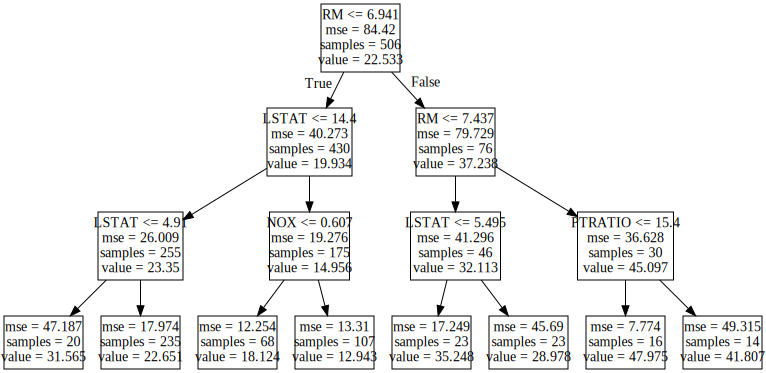

In [8]:
# Use graphviz module
clf = DecisionTreeRegressor(max_depth=best_3_depth['max_depth'], min_samples_leaf=best_3_depth['min_samples_leaf'])
clf.fit(data.data, data.target)
export_graphviz(clf, 'regress_tree.dot',feature_names=data.feature_names)

Source.from_file('regress_tree.dot')

This is interesting. So the label 'accuracy' is misleading in this case, because we actually have the $R^2$ values. So there can be negatives, but over all we find that we can correlate well with the housing value. HOWEVER, if you dig into the data you can find the homes are significantly more valuable in areas where there are lots of teachers for each student (low PTRATIO). Similarly, areas with more rooms (obviously), have higher home values. Also, as is expected a lower poverty ratio leads to higher home values. This isn't surprising, but is super fascinating.

# Problem 4
Do the same thing as #3, but on a large dataset related to your final project. 

In [9]:
# Import datset.
df = pd.read_pickle("recipe_data")

# Experiment with max_depth and min_samples_leaf.
base_info = {"accuracy":0, "time":0, "max_depth":0, "min_samples_leaf":0, "method": "none"}
meta_data = []

for max_depth in range(2,20):
    for min_samples_leaf in range(1,102,10):
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        train_d = base_info.copy()
        test_d = base_info.copy()
        
        start = time.time()
        acc = np.mean(cross_val_score(clf, df[['calories','fat', 'protein', 'sodium']], df['rating'], cv=3))
        
        train_d['time'] = time.time() - start
        train_d['max_depth'] = max_depth
        train_d['min_samples_leaf'] = min_samples_leaf
        train_d['method'] = 'train'
        
        test_d['accuracy'] = acc
        test_d['time'] = time.time() - start
        test_d['max_depth'] = max_depth
        test_d['min_samples_leaf'] = min_samples_leaf
        test_d['method'] = 'test'
        meta_data.append(train_d)
        meta_data.append(test_d)
        
# once again, this is just a convoluted way to get the visualization while saving data so it's logged well
best_train_time = min([i for i in meta_data if i['method'] == 'train'], key=lambda x:x['time'])
print("\nbest train time:",
      "".join(["Time: "+ str(best_train_time['time']) +"\n",
               "Max Depth: "+ str(best_train_time['max_depth']) +"\n",
               "Min Samples Leaf: "+ str(best_train_time['min_samples_leaf'])])
      , sep="\n")

best_test_time = min([i for i in meta_data if i['method'] == 'test'], key=lambda x:x['time'])
print("\nbest test time:",
      "".join(["Time: "+ str(best_test_time['time']) +"\n",
               "Max Depth: "+ str(best_test_time['max_depth']) +"\n",
               "Min Samples Leaf: "+ str(best_test_time['min_samples_leaf']) + "\n",
               "Accuracy: "+ str(best_test_time['accuracy'])])
      , sep="\n")

best_test_accuracy = max([i for i in meta_data if i['method'] == 'test'], key=lambda x:x['accuracy'])
print("\nbest test accuracy:",
      "".join(["Time: "+ str(best_test_accuracy['time']) +"\n",
               "Max Depth: "+ str(best_test_accuracy['max_depth']) +"\n",
               "Min Samples Leaf: "+ str(best_test_accuracy['min_samples_leaf']) + "\n",
               "Accuracy: "+ str(best_test_accuracy['accuracy'])])
      , sep="\n")


best_3_depth = max([i for i in meta_data if i['method'] == 'test' and i['max_depth'] == 3], key=lambda x:x['accuracy'])
print("\nbest 3 depth accuracy:",
      "".join(["Time: "+ str(best_3_depth['time']) +"\n",
               "Max Depth: "+ str(best_3_depth['max_depth']) +"\n",
               "Min Samples Leaf: "+ str(best_3_depth['min_samples_leaf']) + "\n",
               "Accuracy: "+ str(best_3_depth['accuracy'])])
      , sep="\n")


best train time:
Time: 0.015018939971923828
Max Depth: 2
Min Samples Leaf: 51

best test time:
Time: 0.015021085739135742
Max Depth: 2
Min Samples Leaf: 51
Accuracy: 0.0243284658756

best test accuracy:
Time: 0.021990060806274414
Max Depth: 3
Min Samples Leaf: 31
Accuracy: 0.0260503112231

best 3 depth accuracy:
Time: 0.021990060806274414
Max Depth: 3
Min Samples Leaf: 31
Accuracy: 0.0260503112231


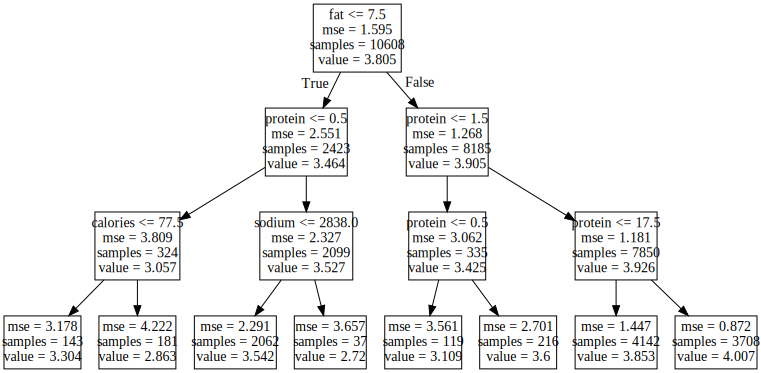

In [10]:
# Use graphviz module
clf = DecisionTreeRegressor(max_depth=best_3_depth['max_depth'], min_samples_leaf=best_3_depth['min_samples_leaf'])
clf.fit(df[['calories','fat', 'protein', 'sodium']], df['rating'])
export_graphviz(clf, 'regress_grocery_tree.dot',feature_names=['calories','fat', 'protein', 'sodium'])

Source.from_file('regress_grocery_tree.dot')

If you notice here that Low Fat, High Protein, and High sodium recipes have a much lower rating than typical. This is quite interesting, it is also interesting to notice that Low Fat, High Protein, and Low Sodium (health diets) typically have high ratings. I prefer the high fat, medium protein 3.853 rating recipies. So this could help me figure out which recipes those are and find them.